In [7]:
! pip install annoy nmslib

In [4]:
%matplotlib inline


# Approximate nearest neighbors in TSNE

This example presents how to chain KNeighborsTransformer and TSNE in a
pipeline. It also shows how to wrap the packages `annoy` and `nmslib` to
replace KNeighborsTransformer and perform approximate nearest neighbors.
These packages can be installed with `pip install annoy nmslib`.

Note: Currently `TSNE(metric='precomputed')` does not modify the precomputed
distances, and thus assumes that precomputed euclidean distances are squared.
In future versions, a parameter in TSNE will control the optional squaring of
precomputed distances (see #12401).

Note: In KNeighborsTransformer we use the definition which includes each
training point as its own neighbor in the count of `n_neighbors`, and for
compatibility reasons, one extra neighbor is computed when
`mode == 'distance'`. Please note that we do the same in the proposed wrappers.

Sample output::

    Benchmarking on MNIST_2000:
    ---------------------------
    AnnoyTransformer:                    0.583 sec
    NMSlibTransformer:                   0.321 sec
    KNeighborsTransformer:               1.225 sec
    TSNE with AnnoyTransformer:          4.903 sec
    TSNE with NMSlibTransformer:         5.009 sec
    TSNE with KNeighborsTransformer:     6.210 sec
    TSNE with internal NearestNeighbors: 6.365 sec

    Benchmarking on MNIST_10000:
    ----------------------------
    AnnoyTransformer:                    4.457 sec
    NMSlibTransformer:                   2.080 sec
    KNeighborsTransformer:               30.680 sec
    TSNE with AnnoyTransformer:          30.225 sec
    TSNE with NMSlibTransformer:         43.295 sec
    TSNE with KNeighborsTransformer:     64.845 sec
    TSNE with internal NearestNeighbors: 64.984 sec


Automatically created module for IPython interactive environment

Benchmarking on MNIST_2000:
---------------------------
AnnoyTransformer:                    2.460 sec
NMSlibTransformer:                   0.173 sec
KNeighborsTransformer:               2.206 sec
TSNE with AnnoyTransformer:          7.510 sec
TSNE with NMSlibTransformer:         5.929 sec
TSNE with KNeighborsTransformer:     8.114 sec
TSNE with internal NearestNeighbors: 9.213 sec

Benchmarking on MNIST_10000:
----------------------------
AnnoyTransformer:                    12.359 sec
NMSlibTransformer:                   1.494 sec
KNeighborsTransformer:               52.123 sec
TSNE with AnnoyTransformer:          51.923 sec
TSNE with NMSlibTransformer:         49.194 sec


KeyboardInterrupt: 

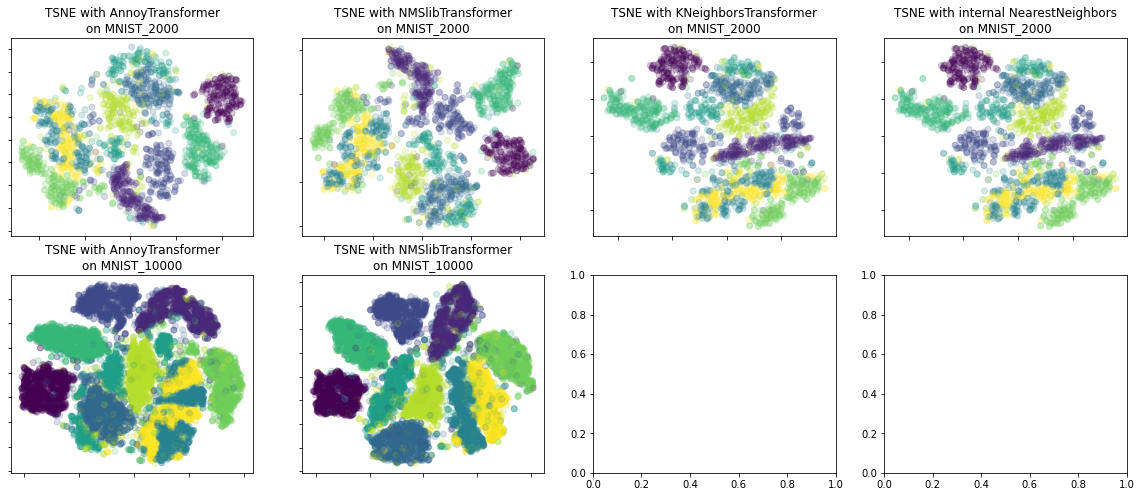

In [8]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
import time
import sys

try:
    import annoy
except ImportError:
    print("The package 'annoy' is required to run this example.")
    sys.exit()

try:
    import nmslib
except ImportError:
    print("The package 'nmslib' is required to run this example.")
    sys.exit()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from scipy.sparse import csr_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsTransformer
from sklearn.utils._testing import assert_array_almost_equal
from sklearn.datasets import fetch_openml
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

print(__doc__)


class NMSlibTransformer(TransformerMixin, BaseEstimator):
    """Wrapper for using nmslib as sklearn's KNeighborsTransformer"""

    def __init__(self, n_neighbors=5, metric='euclidean', method='sw-graph',
                 n_jobs=1):
        self.n_neighbors = n_neighbors
        self.method = method
        self.metric = metric
        self.n_jobs = n_jobs

    def fit(self, X):
        self.n_samples_fit_ = X.shape[0]

        # see more metric in the manual
        # https://github.com/nmslib/nmslib/tree/master/manual
        space = {
            'sqeuclidean': 'l2',
            'euclidean': 'l2',
            'cosine': 'cosinesimil',
            'l1': 'l1',
            'l2': 'l2',
        }[self.metric]

        self.nmslib_ = nmslib.init(method=self.method, space=space)
        self.nmslib_.addDataPointBatch(X)
        self.nmslib_.createIndex()
        return self

    def transform(self, X):
        n_samples_transform = X.shape[0]

        # For compatibility reasons, as each sample is considered as its own
        # neighbor, one extra neighbor will be computed.
        n_neighbors = self.n_neighbors + 1

        results = self.nmslib_.knnQueryBatch(X, k=n_neighbors,
                                             num_threads=self.n_jobs)
        indices, distances = zip(*results)
        indices, distances = np.vstack(indices), np.vstack(distances)

        if self.metric == 'sqeuclidean':
            distances **= 2

        indptr = np.arange(0, n_samples_transform * n_neighbors + 1,
                           n_neighbors)
        kneighbors_graph = csr_matrix((distances.ravel(), indices.ravel(),
                                       indptr), shape=(n_samples_transform,
                                                       self.n_samples_fit_))

        return kneighbors_graph


class AnnoyTransformer(TransformerMixin, BaseEstimator):
    """Wrapper for using annoy.AnnoyIndex as sklearn's KNeighborsTransformer"""

    def __init__(self, n_neighbors=5, metric='euclidean', n_trees=10,
                 search_k=-1):
        self.n_neighbors = n_neighbors
        self.n_trees = n_trees
        self.search_k = search_k
        self.metric = metric

    def fit(self, X):
        self.n_samples_fit_ = X.shape[0]
        metric = self.metric if self.metric != 'sqeuclidean' else 'euclidean'
        self.annoy_ = annoy.AnnoyIndex(X.shape[1], metric=metric)
        for i, x in enumerate(X):
            self.annoy_.add_item(i, x.tolist())
        self.annoy_.build(self.n_trees)
        return self

    def transform(self, X):
        return self._transform(X)

    def fit_transform(self, X, y=None):
        return self.fit(X)._transform(X=None)

    def _transform(self, X):
        """As `transform`, but handles X is None for faster `fit_transform`."""

        n_samples_transform = self.n_samples_fit_ if X is None else X.shape[0]

        # For compatibility reasons, as each sample is considered as its own
        # neighbor, one extra neighbor will be computed.
        n_neighbors = self.n_neighbors + 1

        indices = np.empty((n_samples_transform, n_neighbors),
                           dtype=int)
        distances = np.empty((n_samples_transform, n_neighbors))

        if X is None:
            for i in range(self.annoy_.get_n_items()):
                ind, dist = self.annoy_.get_nns_by_item(
                    i, n_neighbors, self.search_k, include_distances=True)

                indices[i], distances[i] = ind, dist
        else:
            for i, x in enumerate(X):
                indices[i], distances[i] = self.annoy_.get_nns_by_vector(
                    x.tolist(), n_neighbors, self.search_k,
                    include_distances=True)

        if self.metric == 'sqeuclidean':
            distances **= 2

        indptr = np.arange(0, n_samples_transform * n_neighbors + 1,
                           n_neighbors)
        kneighbors_graph = csr_matrix((distances.ravel(), indices.ravel(),
                                       indptr), shape=(n_samples_transform,
                                                       self.n_samples_fit_))

        return kneighbors_graph


def test_transformers():
    """Test that AnnoyTransformer and KNeighborsTransformer give same results
    """
    X = np.random.RandomState(42).randn(10, 2)

    knn = KNeighborsTransformer()
    Xt0 = knn.fit_transform(X)

    ann = AnnoyTransformer()
    Xt1 = ann.fit_transform(X)

    nms = NMSlibTransformer()
    Xt2 = nms.fit_transform(X)

    assert_array_almost_equal(Xt0.toarray(), Xt1.toarray(), decimal=5)
    assert_array_almost_equal(Xt0.toarray(), Xt2.toarray(), decimal=5)


def load_mnist(n_samples):
    """Load MNIST, shuffle the data, and return only n_samples."""
    mnist = fetch_openml("mnist_784")
    X, y = shuffle(mnist.data, mnist.target, random_state=2)
    return X[:n_samples] / 255, y[:n_samples]


def run_benchmark():
    datasets = [
        ('MNIST_2000', load_mnist(n_samples=2000)),
        ('MNIST_10000', load_mnist(n_samples=10000)),
    ]

    n_iter = 500
    perplexity = 30
    # TSNE requires a certain number of neighbors which depends on the
    # perplexity parameter.
    # Add one since we include each sample as its own neighbor.
    n_neighbors = int(3. * perplexity + 1) + 1

    transformers = [
        ('AnnoyTransformer', AnnoyTransformer(n_neighbors=n_neighbors,
                                              metric='sqeuclidean')),
        ('NMSlibTransformer', NMSlibTransformer(n_neighbors=n_neighbors,
                                                metric='sqeuclidean')),
        ('KNeighborsTransformer', KNeighborsTransformer(
            n_neighbors=n_neighbors, mode='distance', metric='sqeuclidean')),
        ('TSNE with AnnoyTransformer', make_pipeline(
            AnnoyTransformer(n_neighbors=n_neighbors, metric='sqeuclidean'),
            TSNE(metric='precomputed', perplexity=perplexity,
                 method="barnes_hut", random_state=42, n_iter=n_iter), )),
        ('TSNE with NMSlibTransformer', make_pipeline(
            NMSlibTransformer(n_neighbors=n_neighbors, metric='sqeuclidean'),
            TSNE(metric='precomputed', perplexity=perplexity,
                 method="barnes_hut", random_state=42, n_iter=n_iter), )),
        ('TSNE with KNeighborsTransformer', make_pipeline(
            KNeighborsTransformer(n_neighbors=n_neighbors, mode='distance',
                                  metric='sqeuclidean'),
            TSNE(metric='precomputed', perplexity=perplexity,
                 method="barnes_hut", random_state=42, n_iter=n_iter), )),
        ('TSNE with internal NearestNeighbors',
         TSNE(metric='sqeuclidean', perplexity=perplexity, method="barnes_hut",
              random_state=42, n_iter=n_iter)),
    ]

    # init the plot
    nrows = len(datasets)
    ncols = np.sum([1 for name, model in transformers if 'TSNE' in name])
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                             figsize=(5 * ncols, 4 * nrows))
    axes = axes.ravel()
    i_ax = 0

    for dataset_name, (X, y) in datasets:

        msg = 'Benchmarking on %s:' % dataset_name
        print('\n%s\n%s' % (msg, '-' * len(msg)))

        for transformer_name, transformer in transformers:
            start = time.time()
            Xt = transformer.fit_transform(X)
            duration = time.time() - start

            # print the duration report
            longest = np.max([len(name) for name, model in transformers])
            whitespaces = ' ' * (longest - len(transformer_name))
            print('%s: %s%.3f sec' % (transformer_name, whitespaces, duration))

            # plot TSNE embedding which should be very similar across methods
            if 'TSNE' in transformer_name:
                axes[i_ax].set_title(transformer_name + '\non ' + dataset_name)
                axes[i_ax].scatter(Xt[:, 0], Xt[:, 1], c=y.astype(np.int32),
                                   alpha=0.2, cmap=plt.cm.viridis)
                axes[i_ax].xaxis.set_major_formatter(NullFormatter())
                axes[i_ax].yaxis.set_major_formatter(NullFormatter())
                axes[i_ax].axis('tight')
                i_ax += 1

    fig.tight_layout()
    plt.show()


if __name__ == '__main__':
    test_transformers()
    run_benchmark()